In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [57]:
data=pd.read_csv(r'C:\Users\wijdan\Desktop\Costumer feedback satisfaction.csv') 

In [58]:
print("Aperçu des données :")
print(data.head())
print("\nInformations sur les données :")
print(data.info())
print("\nStatistiques descriptives :")
print(data.describe())

Aperçu des données :
   CustomerID  Age  Gender Country  Income  ProductQuality  ServiceQuality  \
0           1   56    Male      UK   83094               5               8   
1           2   69    Male      UK   86860              10               2   
2           3   46  Female     USA   60173               8              10   
3           4   32  Female      UK   73884               7              10   
4           5   60    Male      UK   97546               6               4   

   PurchaseFrequency FeedbackScore LoyaltyLevel  SatisfactionScore  
0                  5           Low       Bronze              100.0  
1                  8        Medium         Gold              100.0  
2                 18        Medium       Silver              100.0  
3                 16           Low         Gold              100.0  
4                 13           Low       Bronze               82.0  

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries,

# Encodage des variables catégorique

In [59]:
label_encoders = {}
categorical_cols = ['Gender', 'Country', 'FeedbackScore', 'LoyaltyLevel']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Normalisation des données

In [60]:
scaler = StandardScaler()
numerical_cols = ['Age', 'Income', 'ProductQuality', 'ServiceQuality', 'PurchaseFrequency']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Convertir les données en format binaire pour Apriori

In [61]:
basket = data[['ProductQuality', 'ServiceQuality', 'FeedbackScore', 'LoyaltyLevel']]
basket = basket.applymap(lambda x: 1 if x > basket.mean().mean() else 0)

# Appliquer l'algorithme Apriori

In [62]:
frequent_itemsets = apriori(basket, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nRules from Apriori:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Rules from Apriori:
        antecedents       consequents   support  confidence      lift
0  (ProductQuality)   (FeedbackScore)  0.266648    0.667339  1.005061
1   (FeedbackScore)  (ProductQuality)  0.266648    0.401591  1.005061
2  (ProductQuality)    (LoyaltyLevel)  0.267116    0.668511  1.002350
3    (LoyaltyLevel)  (ProductQuality)  0.267116    0.400507  1.002350
4   (FeedbackScore)  (ServiceQuality)  0.263916    0.397477  1.003125
5  (ServiceQuality)   (FeedbackScore)  0.263916    0.666054  1.003125
6   (FeedbackScore)    (LoyaltyLevel)  0.443086    0.667320  1.000563
7    (LoyaltyLevel)   (FeedbackScore)  0.443086    0.664353  1.000563


# Affichage des règles d'associations

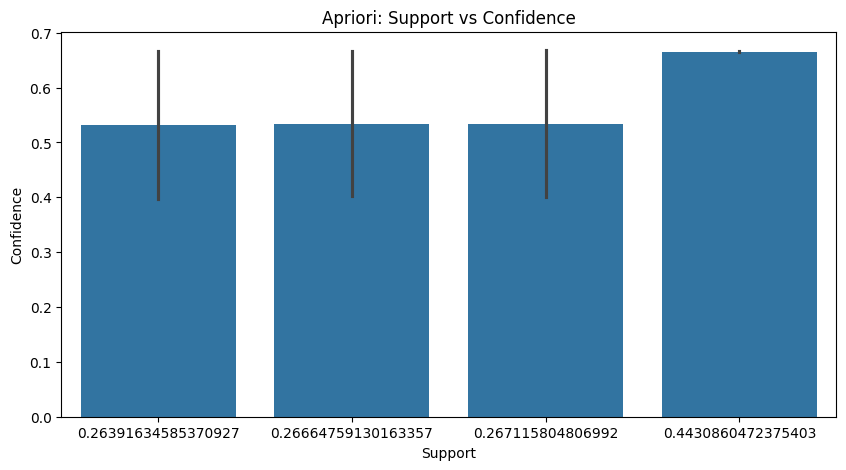

In [63]:
plt.figure(figsize=(10,5))
sns.barplot(x=rules['support'], y=rules['confidence'])
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Apriori: Support vs Confidence')
plt.show()

# K-Means Clustering 

# Trouver le nombre optimal de clusters

In [64]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data[numerical_cols])
    wcss.append(kmeans.inertia_)

# Tracer la courbe du coude

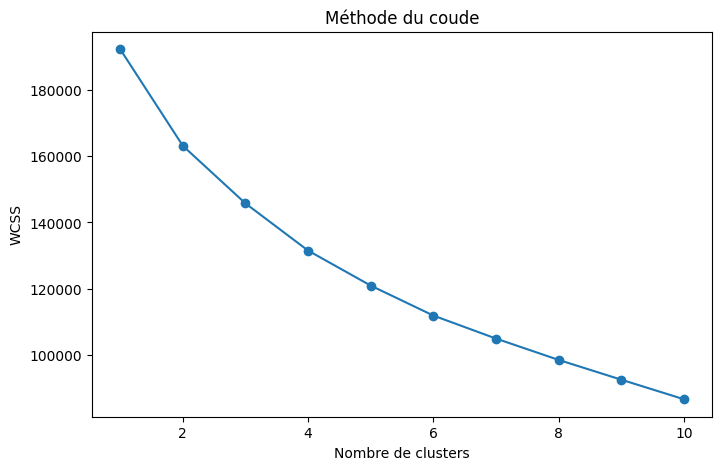

In [65]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('Méthode du coude')
plt.show()

# Appliquer K-Means avec 3 clusters 

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(data[numerical_cols])

# Visualisation des clusters

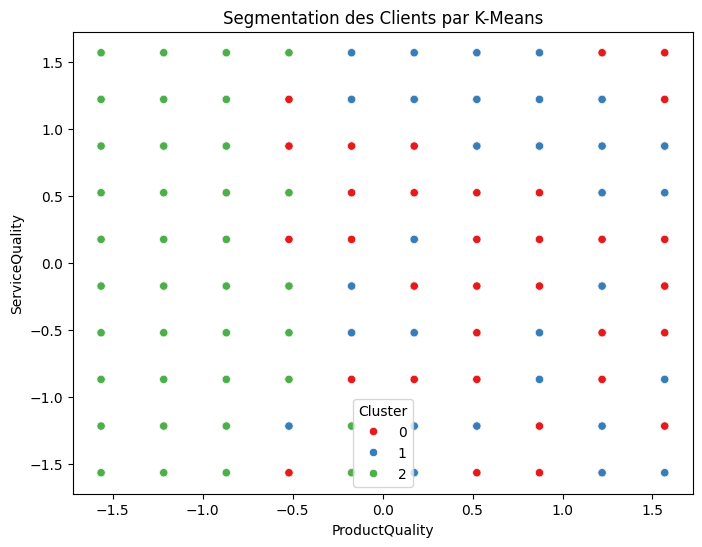

In [46]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=data['ProductQuality'], y=data['ServiceQuality'], hue=data['Cluster'], palette='Set1')
plt.title("Segmentation des Clients par K-Means")
plt.show()

# K-NN (K-Nearest Neighbors )

# Séparation des données

In [47]:
X = data[numerical_cols]
y_satisfaction = data['SatisfactionScore'] > data['SatisfactionScore'].mean()  # Label binaire (satisfait ou non)
y_loyalty = data['LoyaltyLevel'] > data['LoyaltyLevel'].mean()
y_feedback = data['FeedbackScore'] > data['FeedbackScore'].mean()

# Modèle K-NN pour Satisfaction

In [49]:
knn_satisfaction = KNeighborsClassifier(n_neighbors=5)
knn_satisfaction.fit(X, y_satisfaction)
data['PredictedSatisfaction'] = knn_satisfaction.predict(X)

# K-NN pour Loyalty Level

In [50]:
knn_loyalty = KNeighborsClassifier(n_neighbors=5)
knn_loyalty.fit(X, y_loyalty)
data['PredictedLoyaltyLevel'] = knn_loyalty.predict(X)

# K-NN pour FeedBack Score

In [51]:
knn_feedback = KNeighborsClassifier(n_neighbors=5)
knn_feedback.fit(X, y_feedback)
data['PredictedFeedbackScore'] = knn_feedback.predict(X)

# Afficher les résultats

In [53]:
print("\nClassification K-NN:")
print(data[['SatisfactionScore', 'PredictedSatisfaction', 'LoyaltyLevel', 'PredictedLoyaltyLevel', 'FeedbackScore', 'PredictedFeedbackScore']].head())


Classification K-NN:
   SatisfactionScore  PredictedSatisfaction  LoyaltyLevel  \
0              100.0                   True             0   
1              100.0                   True             1   
2              100.0                   True             2   
3              100.0                   True             1   
4               82.0                   True             0   

   PredictedLoyaltyLevel  FeedbackScore  PredictedFeedbackScore  
0                  False              1                    True  
1                   True              2                    True  
2                   True              2                    True  
3                   True              1                   False  
4                   True              1                    True  


# Diagramme de distribution des prédictions

C:\Users\wijdan\AppData\Local\Temp\ipykernel_19140\186700362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['PredictedSatisfaction'], palette='coolwarm')


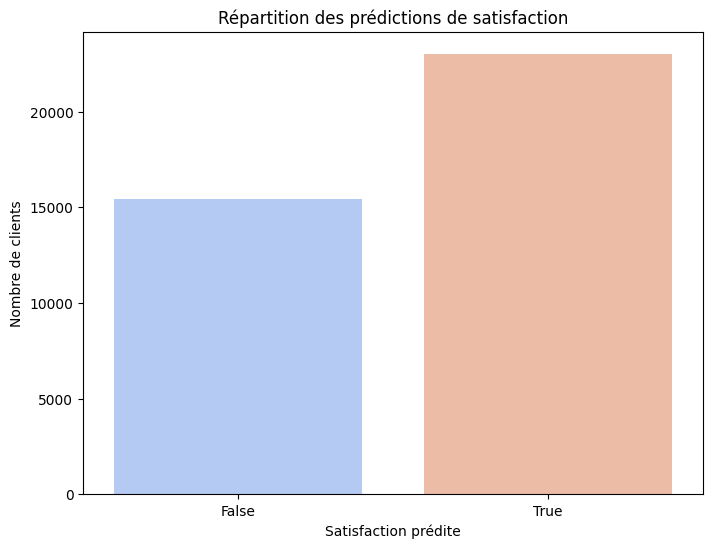

C:\Users\wijdan\AppData\Local\Temp\ipykernel_19140\186700362.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['PredictedLoyaltyLevel'], palette='coolwarm')


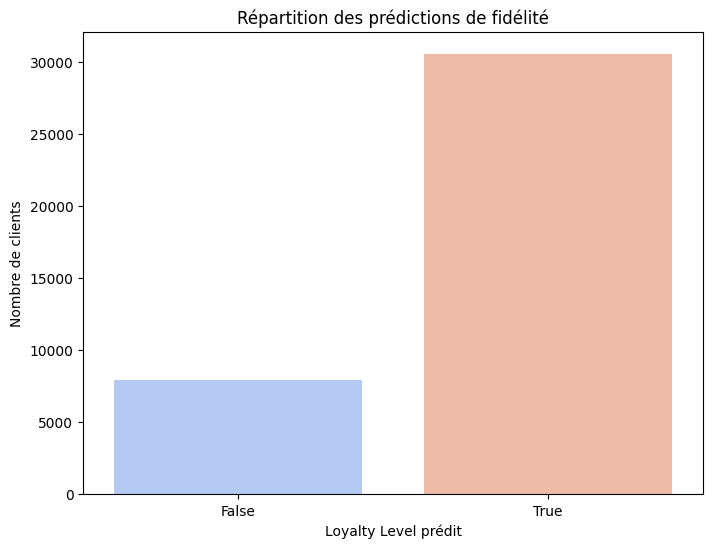

C:\Users\wijdan\AppData\Local\Temp\ipykernel_19140\186700362.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['PredictedFeedbackScore'], palette='coolwarm')


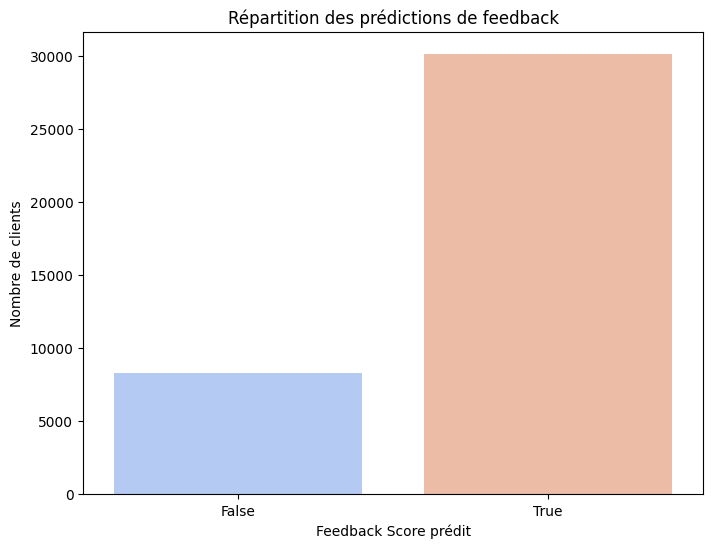

In [55]:
plt.figure(figsize=(8,6))
sns.countplot(x=data['PredictedSatisfaction'], palette='coolwarm')
plt.xlabel("Satisfaction prédite")
plt.ylabel("Nombre de clients")
plt.title("Répartition des prédictions de satisfaction")
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x=data['PredictedLoyaltyLevel'], palette='coolwarm')
plt.xlabel("Loyalty Level prédit")
plt.ylabel("Nombre de clients")
plt.title("Répartition des prédictions de fidélité")
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x=data['PredictedFeedbackScore'], palette='coolwarm')
plt.xlabel("Feedback Score prédit")
plt.ylabel("Nombre de clients")
plt.title("Répartition des prédictions de feedback")
plt.show()